# Trabajo practico 2
Freddy Julian Riascos Salas


# Parte 1

**Punto 1**


In [16]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [115]:
#implementing the algorithm for calculating image quality measure

def read_video_input(path):
    cap = cv.VideoCapture(path)
    if not cap.isOpened():
        raise ValueError("Cannot open video file.")
    return cap

def get_th_blur_measure(frame):
    f = np.fft.fft2(frame)
    fc = np.fft.fftshift(f)
    af = np.abs(fc)
    m = np.max(af)
    threshold = m / 1000
    th = np.sum(af > threshold)
    return th




def compute_th_blur_measure(frame, M, N):
    th = get_th_blur_measure(frame)
    return th / (M * N)

def get_limits_q2_values(image):
    max_index = np.argmax(image)
    start_index = max(0, max_index -10)
    end_index = min(image.size, max_index +10)
    return image[start_index:end_index]

def get_frame_with_portion(frame, roi_portion):
    height, width, _ = frame.shape
    total_area = height * width
    roi_area = (roi_portion / 100) * total_area
    roi_side = int(np.sqrt(roi_area)) 
    center_x, center_y = width // 2, height // 2
    half_side = roi_side // 2
    x1 = max(0, center_x - half_side)
    y1 = max(0, center_y - half_side)
    x2 = min(width, center_x + half_side)
    y2 = min(height, center_y + half_side)
    return x1, y1, x2, y2


def get_frame_with_focus_matrix(frame, N, M):
    height, width, _ = frame.shape
    cell_height = height // N
    cell_width = width // M
    cells = []
    for i in range(N):
        for j in range(M):
            x1 = j * cell_width
            y1 = i * cell_height
            x2 = x1 + cell_width
            y2 = y1 + cell_height
            cells.append(frame[y1:y2, x1:x2])
    return cells
    


def process_video_blur_measure(
    video_path,
    is_roi=False, 
    roi_portion=0, 
    is_focus_matrix=False,
    N=0,
    M=0
):
    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Unable to open video")
    fm_values = []
    frame_indices = []
    frame_index = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        M_dim, N_dim, _ = frame.shape
        if is_roi:
            x1, y1, x2, y2 = get_frame_with_portion(frame, roi_portion)
            frame = frame[y1:y2, x1:x2]
        if is_focus_matrix:
            frame = get_frame_with_focus_matrix(frame,N,M)
            cell_height = M_dim // N
            cell_width = N_dim // M
            M_dim, N_dim = cell_height, cell_width
        fm_value = compute_th_blur_measure(frame, M_dim,N_dim)
        fm_values.append(fm_value)
        frame_indices.append(frame_index)
        frame_index +=1
    cap.release()
    return fm_values, frame_indices
    

def get_limits_focused_image(fm_values,percentile=90):
    focus_threshold = np.percentile(fm_values, percentile)
    focused_frames = [
        idx for idx, value in enumerate(fm_values) if value >= focus_threshold
    ]
    max_focused_value = np.max(fm_values)
    max_focused_index = np.argmax(fm_values)
    return (focused_frames[0], focused_frames[-1], max_focused_value, max_focused_index)

def plot_the_fm_values(
        frame_indices, 
        fm_values, 
        start_index, 
        end_index, 
        max_focused_value,
        max_focused_index):
    plt.figure(figsize=(12,6))
    plt.plot(frame_indices, fm_values, marker='o', linestyle='-', label='ISM')
    plt.axvline(x=start_index, color="green", linestyle="--", label="Focused Image Start")
    plt.axvline(x=end_index, color="red", linestyle="--", label="Focused Image End")
    plt.scatter(max_focused_index, max_focused_value, color="red", s=100, label="Max Focused Image", zorder=5)
    plt.xlabel('Frame #')
    plt.ylabel('ISM')
    plt.title('Frame vs Image Sharpness')
    plt.legend()
    plt.grid(True)
    plt.show()

def is_focused(fm, threshold):
    return fm > threshold

def set_video_with_roi(fm_values, video_input, output_video_path, percentile, roi_percentage):
    
    
    cap = read_video_input(video_input)
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv.CAP_PROP_FPS)
    frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    
    # Calculate ROI dimensions
    total_area = width * height
    roi_area = (roi_percentage / 100) * total_area
    roi_side = int(np.sqrt(roi_area))  # Assuming square ROI
    center_x, center_y = width // 2, height // 2
    half_side = roi_side // 2
    x1, y1 = center_x - half_side, center_y - half_side
    x2, y2 = center_x + half_side, center_y + half_side

    focus_threshold = np.percentile(fm_values, percentile)    
    fourcc = cv.VideoWriter_fourcc(*'mp4v')
    out = cv.VideoWriter(output_video_path, fourcc, fps, (width, height))
    for frame_idx in range(len(fm_values)):
        ret, frame = cap.read()
        if not ret:
            break
        fm = fm_values[frame_idx]
        color = (0, 255, 0) if fm > focus_threshold else (0, 0, 255)
        # Draw ROI on the frame
        frame_with_overlay = frame.copy()
        cv.rectangle(frame_with_overlay, (x1, y1), (x2, y2), color, 2)

        # Write the frame to the output video
        out.write(frame_with_overlay)

        
    cap.release()
    out.release()


def compute_gra1_focus_metric(
    video_path, 
    is_roi=False, 
    roi_portion=5, 
    is_focus_matrix=False,
    N=0,
    M=0):
    cap = read_video_input(video_path)
    focus_metrics = []
    frame_indices = []
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if is_roi:
            x1, y1, x2, y2 = get_frame_with_portion(frame, roi_portion)
            frame = frame[y1:y2, x1:x2]
        if is_focus_matrix:
            frame = get_frame_with_focus_matrix(frame,N,M)
            frame = frame[0]
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        blurred = cv.GaussianBlur(gray, (5, 5), 1)
        
        # Compute gradients using Sobel operator
        grad_x = cv.Sobel(blurred, cv.CV_64F, 1, 0, ksize=3)
        grad_y = cv.Sobel(blurred, cv.CV_64F, 0, 1, ksize=3)

        # Compute focus metric: sum of squared gradients
        focus_metric = np.sum(grad_x**2 + grad_y**2)
        focus_metrics.append(focus_metric)
        frame_indices.append(frame_index)
        frame_index += 1
    
    cap.release()

    focus_metrics = np.array(focus_metrics)
    focus_metrics_normalized = (focus_metrics - focus_metrics.min()) / (focus_metrics.max() - focus_metrics.min())
    return focus_metrics_normalized, frame_indices


def output_results(start_index, end_index, max):
    return f'The algorithm start with a range Focus value in {start_index} and end {end_index} with a max point in {max}'
    

#### **1.1) Frame completo**


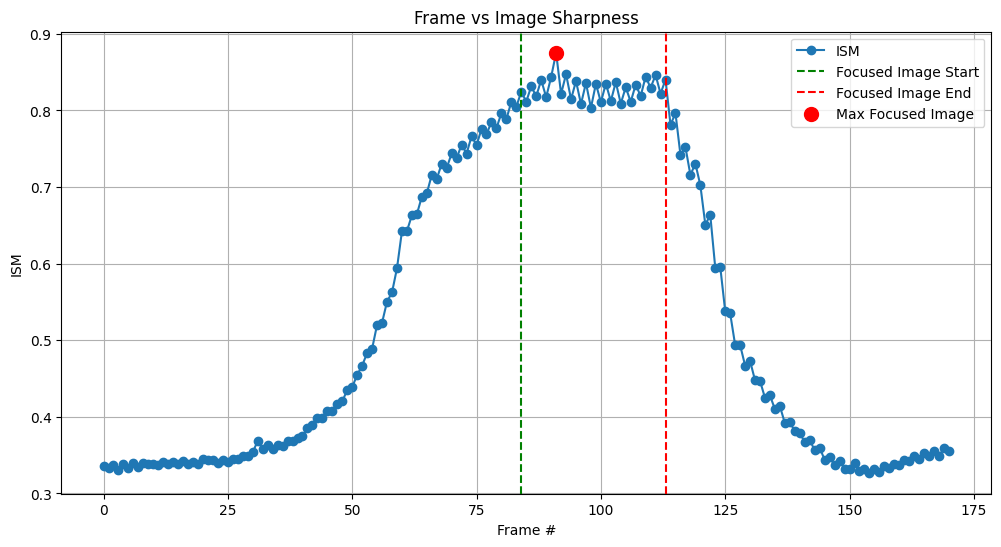

'The algorithm start with a range Focus value in 84 and end 113 with a max point in 0.8753776041666667'

In [116]:
#get the video
video_path = "./TP2/focus_video.mov"
video_output= "./TP2/output_focused_videos/blur_measure-algorithm/all_frame.mp4"

percentile = 90
roi_percentage = 10

fm_values, frame_indices = process_video_blur_measure(video_path)
start_focused, end_focused, max_focused_value, max_focused_index = get_limits_focused_image(fm_values, percentile)

plot_the_fm_values(
    frame_indices, 
    fm_values, 
    start_focused, 
    end_focused, 
    max_focused_value,
    max_focused_index
)

set_video_with_roi(
    fm_values,
    video_path,
    video_output,
    percentile, 
    roi_percentage
)

output_results(start_focused,end_focused, max_focused_value)

#### **1.2) ROI al centro del frame**


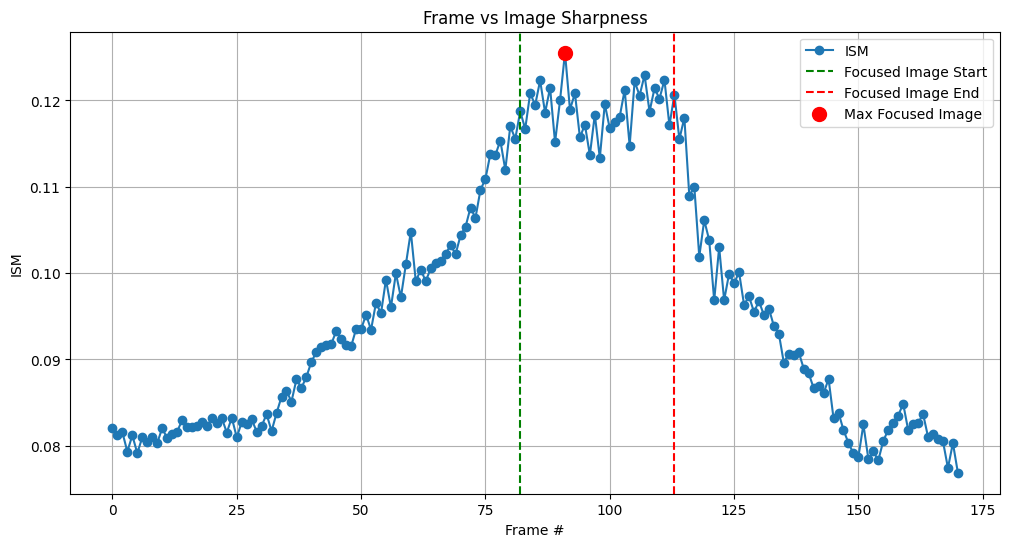

'The algorithm start with a range Focus value in 82 and end 113 with a max point in 0.1255295138888889'

In [121]:
video_path = "./TP2/focus_video.mov"
video_output= "./TP2/output_focused_videos/blur_measure-algorithm/10%_frame.mp4"
percentile = 90
roi_percentage = 10

fm_values, frame_indices = process_video_blur_measure(video_path, True, 5)
start_focused, end_focused, max_focused_value, max_focused_index = get_limits_focused_image(fm_values, percentile)

plot_the_fm_values(
    frame_indices, 
    fm_values, 
    start_focused, 
    end_focused, 
    max_focused_value,
    max_focused_index
)

set_video_with_roi(
    fm_values,
    video_path,
    video_output,
    percentile, 
    roi_percentage
)
output_results(start_focused,end_focused, max_focused_value)

#### **1.3) Matriz de enfoque en el frame**


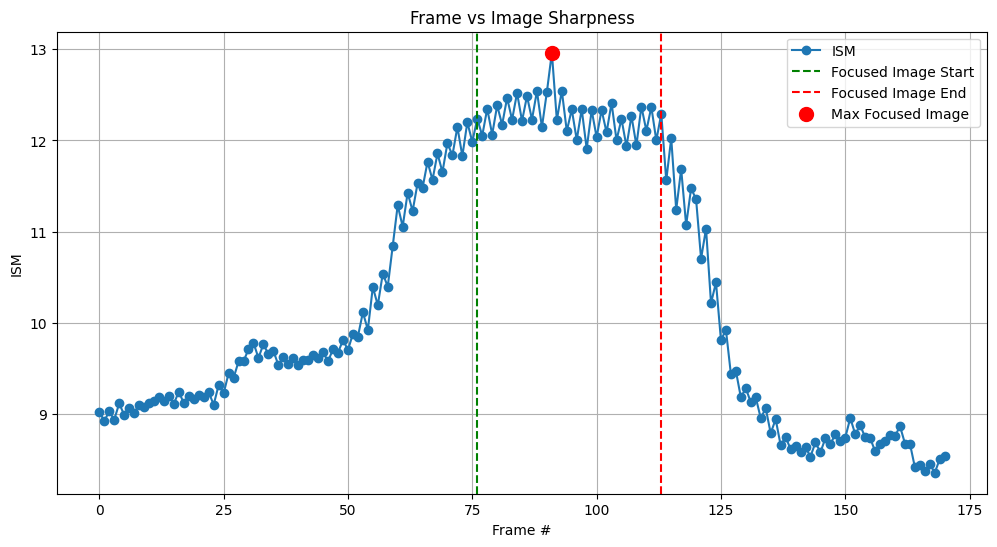

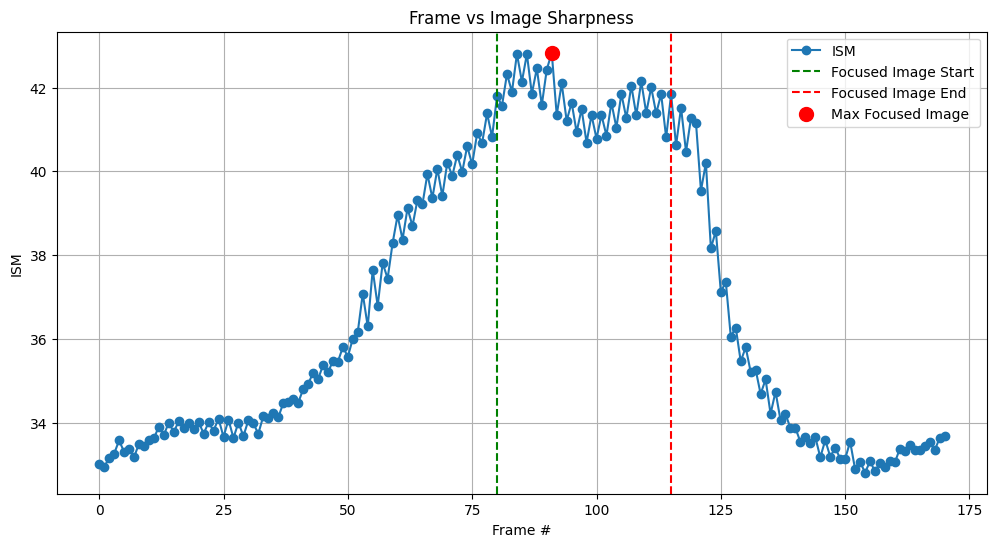

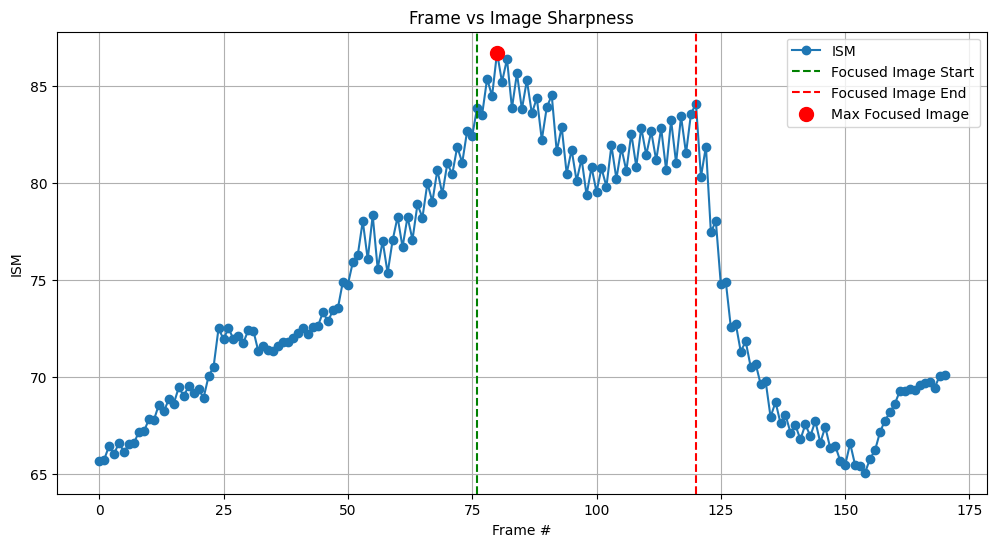

In [120]:
video_path = "./TP2/focus_video.mov"
percentile = 89
roi_percentage = 10

grid_sizes = [(3, 3), (5, 5), (7, 7)]
for grid_size in grid_sizes:
    N, M = grid_size
    fm_values, frame_indices = process_video_blur_measure(
        video_path, 
        is_focus_matrix=True,
        N=N,
        M=M
    )
    start_focused, end_focused, max_focused_value, max_focused_index = get_limits_focused_image(fm_values, percentile)
    plot_the_fm_values(
        frame_indices, 
        fm_values, 
        start_focused, 
        end_focused, 
        max_focused_value,
        max_focused_index
    )
    video_output = f"./TP2/output_focused_videos/blur_measure-algorithm/{M}x{N}-frame.mp4"
    set_video_with_roi(
        fm_values,
        video_path,
        video_output,
        percentile, 
        roi_percentage
    )
    output_results(start_focused,end_focused, max_focused_value)

# Parte 2

#### **2) El algoritmo usado del GRA1 (First-order Gradient)**



#### **2.1) Frame completo**


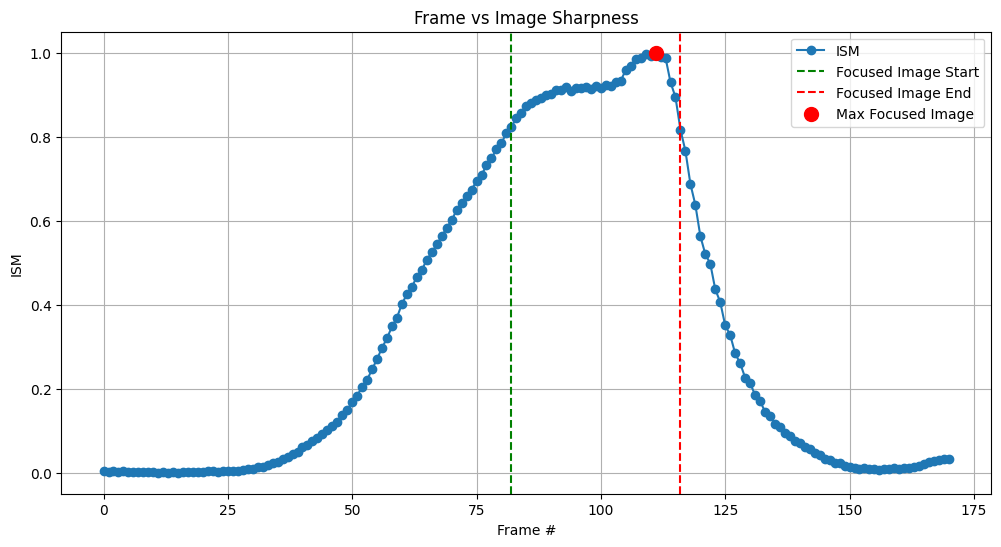

'The algorithm start with a range Focus value in 82 and end 116 with a max point in 1.0'

In [119]:
video_path = "./TP2/focus_video.mov"
video_output= "./TP2/output_focused_videos/gra1/all_frame.mp4"
percentile = 80
roi_percentage = 10

fm_values, frame_indices = compute_gra1_focus_metric(video_path)
start_focused, end_focused, max_focused_value, max_focused_index = get_limits_focused_image(fm_values, percentile)
plot_the_fm_values(
    frame_indices, 
    fm_values, 
    start_focused, 
    end_focused, 
    max_focused_value,
    max_focused_index
)

set_video_with_roi(
    fm_values,
    video_path,
    video_output,
    percentile, 
    roi_percentage
)
output_results(start_focused,end_focused, max_focused_value)

#### **2.2) ROI al centro del frame**


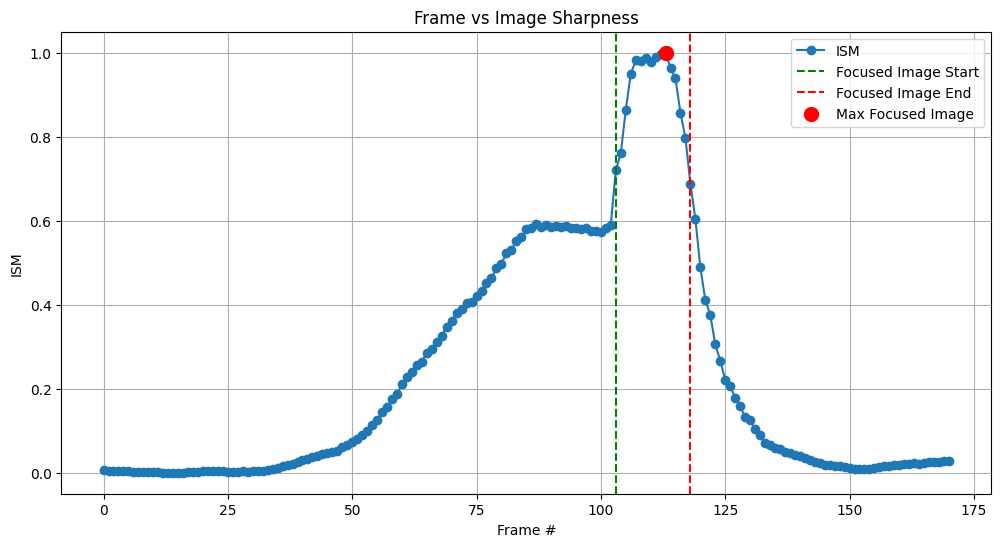

'The algorithm start with a range Focus value in 103 and end 118 with a max point in 1.0'

In [118]:
video_path = "./TP2/focus_video.mov"
video_output= "./TP2/output_focused_videos/gra1/10%_frame.mp4"
percentile = 91
roi_percentage = 10


fm_values, frame_indices = compute_gra1_focus_metric(video_path, True, 10)
start_focused, end_focused, max_focused_value, max_focused_index = get_limits_focused_image(fm_values, percentile)


plot_the_fm_values(
    frame_indices, 
    fm_values, 
    start_focused, 
    end_focused, 
    max_focused_value,
    max_focused_index
)

set_video_with_roi(
    fm_values,
    video_path,
    video_output,
    percentile, 
    roi_percentage
)
output_results(start_focused,end_focused, max_focused_value)

#### **2.3) Matriz de enfoque en el frame**


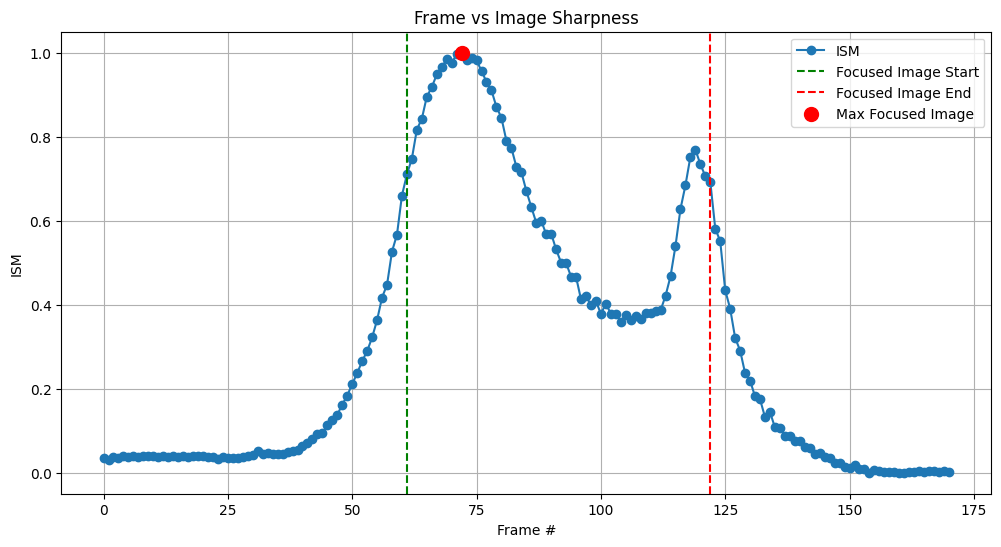

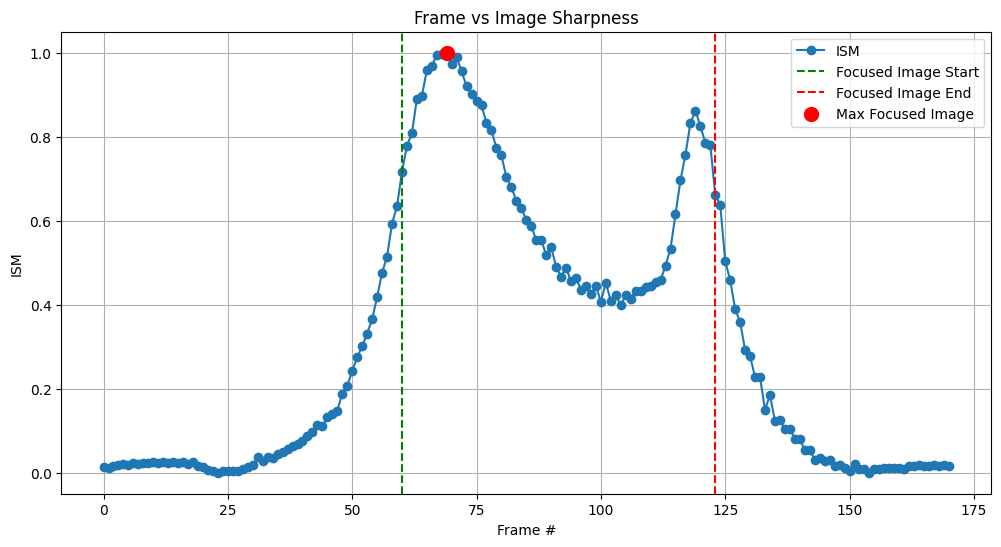

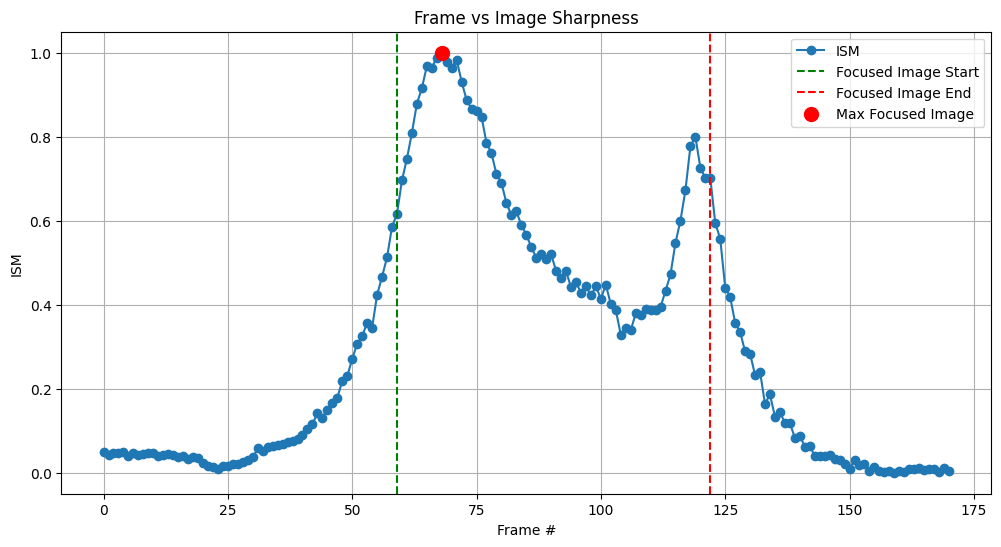

In [122]:
video_path = "./TP2/focus_video.mov"
percentile = 82
roi_percentage = 10

grid_sizes = [(3, 3), (5, 5), (7, 7)]
for grid_size in grid_sizes:
    N, M = grid_size
    fm_values, frame_indices = compute_gra1_focus_metric(
        video_path, 
        is_focus_matrix=True,
        N=N,
        M=M
    )
    start_focused, end_focused, max_focused_value, max_focused_index = get_limits_focused_image(fm_values, percentile)
    plot_the_fm_values(
        frame_indices, 
        fm_values, 
        start_focused, 
        end_focused, 
        max_focused_value,
        max_focused_index
    )
    video_output = f"./TP2/output_focused_videos/gra1/{M}x{N}-frame.mp4"
    set_video_with_roi(
        fm_values,
        video_path,
        video_output,
        percentile, 
        roi_percentage
    )
    output_results(start_focused,end_focused, max_focused_value)